## 🧠 MASTER PROMPT: LOGICAL CLAUSE EXTRACTION + NORMALIZED WEIGHTED REPRESENTATION + PYTHON STRUCTURE

You are a **formal logic expert** specialized in **natural language formalization** and **logical similarity modeling**.

I will give you short argumentative texts.  
Your task is to convert each text into formal logic and provide a detailed **importance-weight distribution** for logical similarity computation, followed by a structured **Python representation**.

---

### 🔧 TASK 1: CLAUSAL FORMALIZATION

For each text:

1. Translate the content into **clausal First-Order Logic (FOL)** in **minimal Conjunctive Normal Form (CNF)**.
2. Fully **instantiate all variables**, using constants found explicitly or implicitly in the context.
3. Apply **semantic normalization** to unify semantically equivalent expressions.
4. Use only the **standard negation symbol** `¬` to represent logical negation (e.g., `¬Allowed(...)`).
5. **Do not use invented negated predicates** (e.g., `NotAllowedTo(...)` is invalid — use `¬Allowed(...)` instead).

#### 🔄 What is normalization?

Normalization transforms **lexically different but semantically equivalent expressions** into **one unified logical form**. This ensures that similar meanings yield similar instances and can be compared for logical similarity.

Normalization applies to both:
- **Predicates** (actions, properties, relations)
- **Constants** (entities, agents, locations, objects)

#### Examples of normalization:

| Original Expression                                           | Normalized Predicate / Constant        |
|---------------------------------------------------------------|----------------------------------------|
| “Adolescent”, “Teen”, “Minor”, "Human under 18"               | `Teenager`                             |
| “Resides in”, “Is located in”                                 | `LivesIn`                              |
| “Purchase”, “Buy”, “Acquire”                                  | `Buy`                                  |
| “France”, “French territory”                                  | `France`                               |
| “Go to jail”, “Be imprisoned”                                 | `ShouldGoToJailFor`                    |
| “Wine”, “Bottle of wine”                                      | `WineBottle`                           |

#### Clause format:

Each clause must:
- Be a **disjunction of ground literals** (no variables).
- Be labeled using the form `<TEXT_ID>_<CLAUSE_ID>` (e.g., `T1_C1`).
- Use literals of the form: `Predicate(Constant1, Constant2, ...)` or `¬Predicate(...)`.
- Each predicate and constant must correspond to a **clear and normalized concept** from the source text.

---

### ⚖️ TASK 2: IMPORTANCE DISTRIBUTION FOR SIMILARITY

For each text, produce a **full distribution of importance weights** over **all logical objects**: predicates and constants.

These weights will be used to assess the **semantic similarity between texts**.

#### 📌 Key principles:

- A **predicate** has high importance if:
  - It encodes the **main action**, rule, or evaluative judgment of the argument.
  - The **polarity** (affirmed or negated) plays a critical role in meaning.
  - Changing or removing it would significantly alter the logical content of the text.

- A **constant** has high importance if:
  - It denotes a **key participant, object, or location** in the argument.
  - Substituting it would lead to a **different event or scenario**.
  - It is central to the **logical scope** of the claims made.

#### ✅ Specific rules:

- Include **every predicate** present in the CNF, **but do not separate based on polarity** in the final dictionary.
  - Instead, compute one weight **per predicate**, based on the **semantic importance of all its polarities** across the text.
- Include **every constant** appearing in the logical clauses.
- **Do not include compound expressions** like `Buy(Bob, Wine)` in the weights. Only include atomic constants (e.g., `"Bob"`, `"WineBottle"`).
- Assign each object a weight in **[0.0, 1.0]**.
- The total sum of all weights (**predicates + constants**) must be **exactly 1.0**.
- If an object is present but irrelevant to the meaning, assign it **weight 0.0**, not omit it.

---

### 🐍 TASK 3: PYTHON TRANSLATION — WEIGHTED LOGICAL STRUCTURE

Translate the logic and importance weights into a **structured Python dictionary** that describes a **weighted logical instance set**.

Each text should be represented as:

```python
weighted_<TEXT_ID> = {
    "instances": frozenset({
        frozenset({  # One instance (full argument context)
            frozenset({("Predicate", ("Constant1", ...))}),   # Clause 1
            frozenset({("¬Predicate", ("ConstantX", ...))}),  # Clause 2
            ...
        }),
        ...
    }),
    "predicate_weights": {
        "Predicate": <weight>,  # One entry per predicate, polarity already accounted for
        ...
    },
    "constant_weights": {
        "Constant": <weight>,   # Atomic constants only
        ...
    }
}
```

Use the symbol "¬Predicate" in the instances, but not in the weight dictionary.
Each instance is a set of clauses, where each clause is a set of literals, and each literal is a (predicate, arguments) tuple.
Ensure that the sum of all weights is exactly 1.0.

✅ Awaiting texts. Return only the final output in the specified format.

In [22]:
from typing import Callable, Any, Set, Tuple, List, FrozenSet, Dict
from functools import lru_cache
from sentence_transformers import SentenceTransformer, util
import inspect

# --- SBERT Helpers ---
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

@lru_cache(maxsize=2048)
def get_embedding(text: str):
    return sbert_model.encode(text, convert_to_tensor=True)

def normalize_str(s: str) -> str:
    return s.lower().replace("_", " ").replace("(", "").replace(")", "").replace("not ", "¬").strip()

def sim_sbert_normalized(a: str, b: str) -> float:
    a_norm, b_norm = normalize_str(a), normalize_str(b)
    return util.cos_sim(get_embedding(a_norm), get_embedding(b_norm)).item()

def pointwise_similarity_weighted(
    args1: List[str],
    args2: List[str],
    simC: Callable[[str, str], float],
    weights1: Dict[str, float],
    weights2: Dict[str, float],
    positional_weight: float = 0.75,
    unordered_penalty: float = 0.25
) -> float:
    if not args1 or not args2:
        return 0.0

    min_len = min(len(args1), len(args2))
    sim_pos, total_weight_pos = 0.0, 0.0
    for i in range(min_len):
        a1, a2 = args1[i], args2[i]
        sim = simC(a1, a2)
        w1 = weights1.get(a1, 0.0)
        w2 = weights2.get(a2, 0.0)
        importance = w1 * w2
        sim_pos += importance * sim
        total_weight_pos += importance
    sim_pos = sim_pos / total_weight_pos if total_weight_pos > 0 else 0.0

    sim_unordered, total_weight_unordered = 0.0, 0.0
    for a1 in args1:
        w1 = weights1.get(a1, 0.0)
        best = 0.0
        for a2 in args2:
            w2 = weights2.get(a2, 0.0)
            sim = simC(a1, a2)
            importance = w1 * w2
            best = max(best, sim * importance)
        sim_unordered += best
        total_weight_unordered += w1
    sim_unordered = sim_unordered / total_weight_unordered if total_weight_unordered > 0 else 0.0

    return positional_weight * sim_pos + (1 - positional_weight) * unordered_penalty * sim_unordered

_seen_debugs = { level: set() for level in ["literal", "clause", "set", "instance"] }
_debug_summary = { level: [] for level in ["literal", "clause", "set", "instance"] }

def simLbert_flexibled_weighted(
    obj1: Tuple[str, Tuple[str, ...]],
    obj2: Tuple[str, Tuple[str, ...]],
    predicate_weights1: Dict[str, float],
    predicate_weights2: Dict[str, float],
    constant_weights1: Dict[str, float],
    constant_weights2: Dict[str, float],
    debug: dict = None
) -> float:
    pred1, args1 = obj1
    pred2, args2 = obj2

    sim_pred = sim_sbert_normalized(pred1, pred2)
    imp_pred = predicate_weights1.get(pred1, 0.0) * predicate_weights2.get(pred2, 0.0)
    num = sim_pred * imp_pred
    denom = imp_pred

    sim_args = pointwise_similarity_weighted(
        list(args1), list(args2), sim_sbert_normalized,
        weights1=constant_weights1,
        weights2=constant_weights2
    )
    imp_args_total = sum(constant_weights1.get(a1, 0.0) * constant_weights2.get(a2, 0.0)
                         for a1 in args1 for a2 in args2)
    num += sim_args * imp_args_total
    denom += imp_args_total

    score = num / denom if denom > 0 else 0.0

    if debug and debug.get("literal", False):
        key = frozenset({obj1, obj2})
        if key not in _seen_debugs["literal"]:
            _seen_debugs["literal"].add(key)
            _debug_summary["literal"].append((obj1, obj2, sim_pred, sim_args, score))
    return score

def generalized_tversky_clause_similarity_powered(
    clause1: Set[Tuple[str, Tuple[str, ...]]],
    clause2: Set[Tuple[str, Tuple[str, ...]]],
    sim_literal: Callable[[Tuple[str, Tuple[str, ...]], Tuple[str, Tuple[str, ...]]], float],
    alpha: float = 1.0,
    beta: float = 1.0,
    p: float = 2.0,
    debug: dict = None
) -> float:
    if not clause1 or not clause2:
        return 0.0

    match_1 = [max(sim_literal(l1, l2) for l2 in clause2) for l1 in clause1]
    match_2 = [max(sim_literal(l2, l1) for l1 in clause1) for l2 in clause2]

    match_1_p = [s ** p for s in match_1]
    match_2_p = [s ** p for s in match_2]

    a = (sum(match_1_p) + sum(match_2_p)) / 2
    b = sum(1 - s for s in match_1_p)
    c = sum(1 - s for s in match_2_p)

    denom = a + alpha * b + beta * c
    score = a / denom if denom > 0 else 0.0

    if debug and debug.get("clause", False):
        _debug_summary["clause"].append(((clause1, clause2), score))
    return score

CLAUSE_SIMILARITY_FUNCTIONS = {
    "generalized_tversky_powered": generalized_tversky_clause_similarity_powered,
}

SET_SIMILARITY_FUNCTIONS = {
    "chamfer": "chamfer",
    "tversky": "tversky",
}

def simClause_simLbert_combined(clause1, clause2, params=None, debug=None, pw1=None, pw2=None, cw1=None, cw2=None):
    level_params = params.get("clause", {})
    clause_strategy = level_params.get("strategy", "tversky_parametric_medianed")
    alpha = level_params.get("alpha", 0.5)
    beta = level_params.get("beta", 0.5)
    p = level_params.get("p", 1.0)

    sim_func = CLAUSE_SIMILARITY_FUNCTIONS.get(clause_strategy)
    if sim_func is None:
        raise ValueError(f"Unknown clause similarity strategy: {clause_strategy}")

    sim_literal = lambda l1, l2: simLbert_flexibled_weighted(
        l1, l2,
        predicate_weights1=pw1, predicate_weights2=pw2,
        constant_weights1=cw1, constant_weights2=cw2,
        debug=debug
    )

    sig = inspect.signature(sim_func)
    kwargs = {"sim_literal": sim_literal, "debug": debug}
    if "alpha" in sig.parameters:
        kwargs["alpha"] = alpha
    if "beta" in sig.parameters:
        kwargs["beta"] = beta
    if "p" in sig.parameters:
        kwargs["p"] = p

    return sim_func(clause1, clause2, **kwargs)

def agg_max(scores: List[float]) -> float:
    return max(scores) if scores else 0.0

def similarity_set_of_sets(set1, set2, sim, method="chamfer", agg=agg_max, alpha=1.0, beta=1.0, debug=None, debug_level=""):
    if not set1 or not set2:
        return 0.0
    def membership(x, S):
        sims = [sim(x, y) for y in S]
        val = max(sims) if method == "chamfer" else agg(sims)
        if debug and debug.get(debug_level, False):
            _debug_summary[debug_level].append((x, val))
        return val
    if method == "chamfer":
        sim_A_to_B = sum(membership(a, set2) for a in set1) / len(set1)
        sim_B_to_A = sum(membership(b, set1) for b in set2) / len(set2)
        return (sim_A_to_B + sim_B_to_A) / 2
    else:
        a_x = sum(membership(x, set2) for x in set1)
        a_y = sum(membership(y, set1) for y in set2)
        a = (a_x + a_y) / 2
        b = sum(1 - membership(x, set2) for x in set1)
        c = sum(1 - membership(y, set1) for y in set2)
        score = a / (a + alpha * b + beta * c) if (a + alpha * b + beta * c) > 0 else 0.0
        _debug_summary[debug_level].append(("TOTAL", a, b, c, score))
        return score

def simSetClause_simLbert_combined(set1, set2, params=None, debug=None, pw1=None, cw1=None, pw2=None, cw2=None):
    level_params = params.get("set", {})
    method = SET_SIMILARITY_FUNCTIONS.get(level_params.get("method", "chamfer"), "chamfer")
    alpha = level_params.get("alpha", 1.0)
    beta = level_params.get("beta", 1.0)
    agg = level_params.get("agg", agg_max)
    return similarity_set_of_sets(
        set1, set2,
        sim=lambda c1, c2: simClause_simLbert_combined(c1, c2, params=params, debug=debug,
                                                       pw1=pw1, cw1=cw1, pw2=pw2, cw2=cw2),
        method=method,
        agg=agg,
        alpha=alpha,
        beta=beta,
        debug=debug,
        debug_level="set"
    )

def simSetSetClause_simLbert_combined_with_summary(wI1, wI2, params=None, debug=None):
    for level in _seen_debugs:
        _seen_debugs[level].clear()
    for level in _debug_summary:
        _debug_summary[level].clear()
    set1 = wI1["instances"]
    set2 = wI2["instances"]
    pw1 = wI1["predicate_weights"]
    pw2 = wI2["predicate_weights"]
    cw1 = wI1["constant_weights"]
    cw2 = wI2["constant_weights"]
    level_params = params.get("instance", {})
    method = SET_SIMILARITY_FUNCTIONS.get(level_params.get("method", "tversky"), "tversky")
    alpha = level_params.get("alpha", 1.0)
    beta = level_params.get("beta", 1.0)
    agg = level_params.get("agg", agg_max)
    score = similarity_set_of_sets(
        set1, set2,
        sim=lambda f1, f2: simSetClause_simLbert_combined(
            f1, f2, params=params, debug=debug,
            pw1=pw1, cw1=cw1, pw2=pw2, cw2=cw2
        ),
        method=method,
        agg=agg,
        alpha=alpha,
        beta=beta,
        debug=debug,
        debug_level="instance"
    )
    return score, _debug_summary


In [23]:
def summarize_debug_output(summary: dict, debug: dict = None, top_n: int = 10):
    def symbol(score: float) -> str:
        return (
            f"{score:.3f} ✅" if score >= 0.9 else
            f"{score:.3f} 🟡" if score >= 0.7 else
            f"{score:.3f} 🟠" if score >= 0.5 else
            f"{score:.3f} 🔴"
        )

    print("\n🔍 SUMMARY OF SIMILARITY COMPARISON\n")
    shown_literals = set()
    shown_clauses = set()
    shown_sets = set()
    shown_instances = set()

    # LITERAL SIMILARITIES
    if debug.get("literal", False):
        print("📌 LITERAL SIMILARITIES (top distinct matches)")
        literals = summary.get("literal", [])
        pairs = {}
        for a, b, _, _, score in literals:
            if a == b:
                continue
            key = tuple(sorted((str(a), str(b))))
            if key not in pairs or score > pairs[key]:
                pairs[key] = score
        sorted_pairs = sorted(pairs.items(), key=lambda x: -x[1])[:top_n]
        if sorted_pairs:
            for (a, b), s in sorted_pairs:
                if (a, b) not in shown_literals and (b, a) not in shown_literals:
                    print(f"  {a} ⇄ {b} → similarity: {symbol(s)}")
                    shown_literals.add((a, b))
        else:
            print("  (no literal similarities computed)")

    # CLAUSE SIMILARITIES
    if debug.get("clause", False):
        print("\n📌 CLAUSE SIMILARITIES (top distinct matches)")
        clauses = summary.get("clause", [])
        pairs = {}
        for item in clauses:
            if len(item) == 3:
                msg, clause1, clause2 = item
                score_str = msg.split("score=")[-1].split(",")[0].strip(")")
                try:
                    score = float(score_str)
                except ValueError:
                    continue
            elif len(item) == 2:
                (clause1, clause2), score = item
            else:
                continue

            key = tuple(sorted((str(clause1), str(clause2))))
            if key not in pairs or score > pairs[key]:
                pairs[key] = score

        sorted_pairs = sorted(pairs.items(), key=lambda x: -x[1])[:top_n]
        if sorted_pairs:
            for (a, b), s in sorted_pairs:
                if (a, b) not in shown_clauses and (b, a) not in shown_clauses:
                    print(f"  {a} ⇄ {b} → similarity: {symbol(s)}")
                    shown_clauses.add((a, b))
        else:
            print("  (no clause similarity computed)")

    # SET SIMILARITIES
    if debug.get("set", False):
        print("\n📌 SET SIMILARITIES (per clause set)")
        sets = summary.get("set", [])
        has_set = False
        for item in sets:
            if isinstance(item, tuple) and len(item) == 2 and item[0] != "TOTAL":
                key = str(item[0])
                if key not in shown_sets:
                    print(f"  Clause set {key} → similarity: {symbol(item[1])}")
                    shown_sets.add(key)
                    has_set = True
        if not has_set:
            print("  (no set similarity computed)")

    # INSTANCE SIMILARITY
    if debug.get("instance", False):
        print("\n📌 INSTANCE SIMILARITY (global set-of-sets score)")
        instances = summary.get("instance", [])
        total = next((x for x in instances if x and x[0] == "TOTAL"), None)
        individual = [x for x in instances if x and x[0] != "TOTAL"]

        if total and len(total) == 10:
            _, a, b, c, score = total
            print(f"  Global similarity = {symbol(score)}")
            print(f"    a = matched: {symbol(a)}")
            print(f"    b = unmatched source: {symbol(b)}")
            print(f"    c = unmatched target: {symbol(c)}")
        else:
            print("  (no global similarity computed)")

        for inst, score in individual:
            key = str(inst)
            if key not in shown_instances:
                print(f"  Instance {key} → best match similarity: {symbol(score)}")
                shown_instances.add(key)
        if not individual:
            print("  (no individual instance matches)")


In [24]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt

def summarize_debug_statistics(summary):
    print("\n🔍 STATISTICAL SUMMARY PER LEVEL")
    for level, entries in summary.items():
        if not entries:
            continue
        if level == "literal":
            sims = [s for *_, s in entries]
        elif level == "clause":
            sims = [score for (_, score) in entries]
        elif level in {"set", "instance"}:
            sims = [score for *_, score in entries if isinstance(score, float)]
        else:
            continue
        print(f"\n📎 Level: {level.upper()}")
        print(f"  - Count: {len(sims)}")
        print(f"  - Min: {min(sims):.3f}")
        print(f"  - Max: {max(sims):.3f}")
        print(f"  - Mean: {statistics.mean(sims):.3f}")
        print(f"  - Stdev: {statistics.stdev(sims):.3f}" if len(sims) > 1 else "  - Stdev: N/A")
        low = [s for s in sims if s < 0.3]
        print(f"  - < 0.3: {len(low)} cases ({len(low)/len(sims)*100:.1f}%)")

def plot_similarity_distribution(summary):
    data = []
    for level, entries in summary.items():
        if not entries:
            continue
        if level == "literal":
            sims = [s for *_, s in entries]
        elif level == "clause":
            sims = [score for (_, score) in entries]
        elif level in {"set", "instance"}:
            sims = [score for *_, score in entries if isinstance(score, float)]
        else:
            continue
        data.extend([(level, s) for s in sims])

    df = pd.DataFrame(data, columns=["level", "similarity"])
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    df.boxplot(by="level", column="similarity", grid=False, ax=ax)
    plt.title("Similarity Distribution per Level (Boxplot)")
    plt.suptitle("")
    plt.xlabel("Level")
    plt.ylabel("Similarity")

    ax = plt.subplot(1, 2, 2)
    df.groupby("level")["similarity"].plot(kind="hist", alpha=0.6, legend=True, bins=10)
    plt.title("Similarity Score Histograms per Level")
    plt.xlabel("Similarity")
    plt.tight_layout()
    plt.show()

def summarize_explanation(summary, params):
    print("\n📋 EXPLANATION SUMMARY BY LEVEL")
    for level, entries in summary.items():
        print(f"\n🔹 Level: {level.upper()}")
        if not entries:
            print("  (No entries)")
            continue

        # Sort entries by score
        if level == "literal":
            entries_sorted = sorted(entries, key=lambda x: x[-1], reverse=True)
        elif level == "clause":
            entries_sorted = sorted(entries, key=lambda x: x[1], reverse=True)
        else:
            entries_sorted = sorted(entries, key=lambda x: x[-1] if isinstance(x[-1], float) else 0.0, reverse=True)

        # Top 3 + scores > 0.8
        top3 = entries_sorted[:3]
        high_scores = [e for e in entries_sorted if (e[-1] if isinstance(e[-1], float) else 0.0) > 0.8 and e not in top3]

        for entry in top3:
            print(f"  ⭐ Top: {entry}")
        for entry in high_scores:
            print(f"  ✅ High (>0.8): {entry}")




🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('Teasing', ('Monkey', 'Dog')) → similarity: 0.680 🟠
  ('AtLocation', ('Dog', 'Zoo')) ⇄ ('Teasing', ('Dog', 'Monkey')) → similarity: 0.675 🟠
  ('Teasing', ('Dog', 'Monkey')) ⇄ ('Teasing', ('Monkey', 'Dog')) → similarity: 0.495 🔴
  ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo')) → similarity: 0.422 🔴
  ('AtLocation', ('Dog', 'Zoo')) ⇄ ('Teasing', ('Monkey', 'Dog')) → similarity: 0.336 🔴
  ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('Teasing', ('Dog', 'Monkey')) → similarity: 0.332 🔴

📌 CLAUSE SIMILARITIES (top distinct matches)
  frozenset({('AtLocation', ('Dog', 'Zoo'))}) ⇄ frozenset({('AtLocation', ('Dog', 'Zoo'))}) → similarity: 0.664 🟠
  frozenset({('AtLocation', ('Monkey', 'Zoo'))}) ⇄ frozenset({('AtLocation', ('Monkey', 'Zoo'))}) → similarity: 0.664 🟠
  frozenset({('AtLocation', ('Dog', 'Zoo'))}) ⇄ frozenset({('Teasing', ('Dog', 'Monkey'))}) → simila

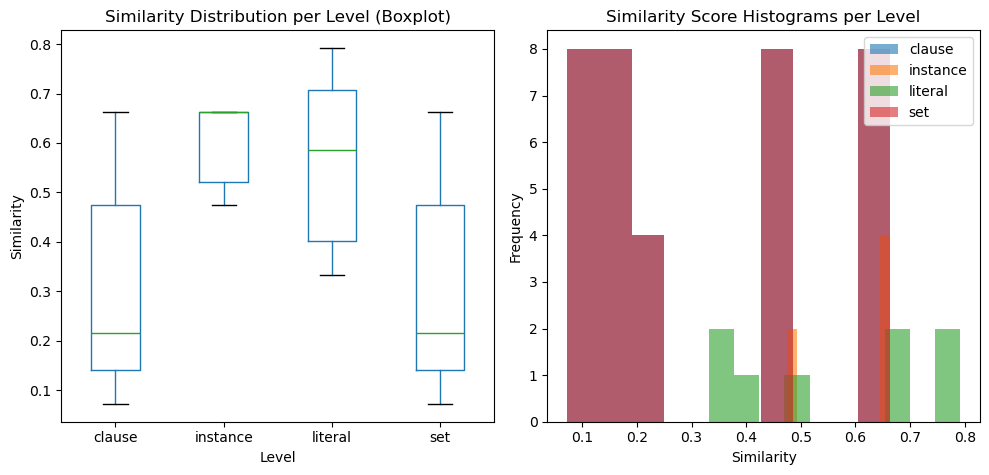

In [25]:
# --- Données pondérées pour I_SA ---
weighted_I_SA = {
    "instances": frozenset({
        frozenset({frozenset({("Teasing", ("Dog", "Monkey"))})}),
        frozenset({frozenset({("AtLocation", ("Dog", "Zoo"))})}),
        frozenset({frozenset({("AtLocation", ("Monkey", "Zoo"))})}),
    }),
    "predicate_weights": {
        "Teasing": 0.3,
        "AtLocation": 0.1,
    },
    "constant_weights": {
        "Dog": 0.3,
        "Monkey": 0.3,
        "Zoo": 0.0
    }
}

# --- Données pondérées pour I_SB ---
weighted_I_SB = {
    "instances": frozenset({
        frozenset({frozenset({("Teasing", ("Monkey", "Dog"))})}),
        frozenset({frozenset({("AtLocation", ("Dog", "Zoo"))})}),
        frozenset({frozenset({("AtLocation", ("Monkey", "Zoo"))})}),
    }),
    "predicate_weights": {
        "Teasing": 0.3,
        "AtLocation": 0.1,
    },
    "constant_weights": {
        "Dog": 0.3,
        "Monkey": 0.3,
        "Zoo": 0.0
    }
}


# --- Paramètres de similarité configurables par niveau ---
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_I_SA, weighted_I_SB, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)



🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('Allowed', ('Buy(Bob, Alcohol)',)) ⇄ ('Allowed', ('Buy(Bob, WineBottle)',)) → similarity: 1.000 ✅
  ('Illegal', ('Buy(Bob, Alcohol)',)) ⇄ ('Illegal', ('Buy(Bob, WineBottle)',)) → similarity: 1.000 ✅
  ('Buy', ('Bob', 'Alcohol')) ⇄ ('Buy', ('Bob', 'WineBottle')) → similarity: 0.818 🟡
  ('Buy', ('Bob', 'WineBottle')) ⇄ ('¬Teenager', ('Bob',)) → similarity: 0.759 🟡
  ('¬ShouldGoToJailFor', ('Bob', 'Buy(Bob, WineBottle)')) ⇄ ('¬Teenager', ('Bob',)) → similarity: 0.759 🟡
  ('¬LivesIn', ('Bob', 'France')) ⇄ ('¬Teenager', ('Bob',)) → similarity: 0.759 🟡
  ('¬Buy', ('Bob', 'WineBottle')) ⇄ ('¬Teenager', ('Bob',)) → similarity: 0.759 🟡
  ('Buy', ('Bob', 'WineBottle')) ⇄ ('¬ShouldGoToJailFor', ('Bob', 'Buy(Bob, Alcohol)')) → similarity: 0.759 🟡
  ('¬ShouldGoToJailFor', ('Bob', 'Buy(Bob, Alcohol)')) ⇄ ('¬ShouldGoToJailFor', ('Bob', 'Buy(Bob, WineBottle)')) → similarity: 0.759 🟡
  ('¬ShouldGoToJailFor', ('Bob', '

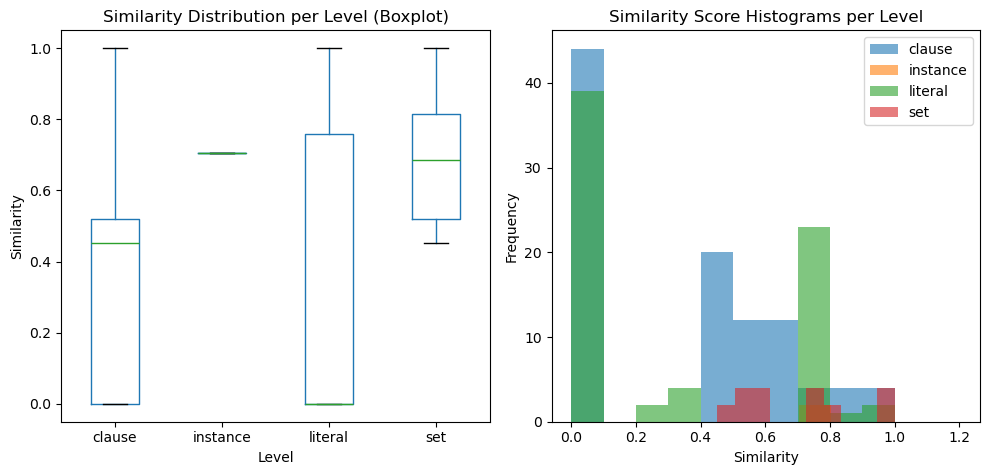

In [26]:
weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("¬Teenager", ("Bob",)), ("¬LivesIn", ("Bob", "France")), ("¬Buy", ("Bob", "Alcohol")), ("¬Allowed", ("Buy(Bob, Alcohol)",))}),
            frozenset({("Allowed", ("Buy(Bob, Alcohol)",)), ("Illegal", ("Buy(Bob, Alcohol)",))}),
            frozenset({("Buy", ("Bob", "Alcohol"))}),
            frozenset({("Illegal", ("Buy(Bob, Alcohol)",))}),
            frozenset({("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, Alcohol)"))}),
        })
    }),
    "predicate_weights": {
        "Teenager": 0.05,
        "LivesIn": 0.05,
        "Buy": 0.15,
        "Allowed": 0.15,
        "Illegal": 0.15,
        "ShouldGoToJailFor": 0.25
    },
    "constant_weights": {
        "Bob": 0.15,
        "France": 0.025,
        "Alcohol": 0.05
    }
}


weighted_T3 = {
    "instances": frozenset({
        frozenset({
            frozenset({("¬Teenager", ("Bob",)), ("¬LivesIn", ("Bob", "France")), ("¬Buy", ("Bob", "WineBottle")), ("¬Allowed", ("Buy(Bob, WineBottle)",))}),
            frozenset({("Allowed", ("Buy(Bob, WineBottle)",)), ("Illegal", ("Buy(Bob, WineBottle)",))}),
            frozenset({("Buy", ("Bob", "WineBottle"))}),
            frozenset({("¬Severe", ("Buy(Bob, WineBottle)",)), ("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, WineBottle)"))}),
            frozenset({("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, WineBottle)"))}),
        })
    }),
    "predicate_weights": {
        "Teenager": 0.05,
        "LivesIn": 0.05,
        "Buy": 0.15,
        "Allowed": 0.15,
        "Illegal": 0.10,
        "Severe": 0.05,
        "ShouldGoToJailFor": 0.25
    },
    "constant_weights": {
        "Bob": 0.15,
        "France": 0.025,
        "WineBottle": 0.05
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# PARAMS OPTIMISÉ POUR L’ADAPTATIVITÉ DES SIMILARITÉS

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_T1, weighted_T3, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)


🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('Eating', ('3Man', 'Kitchen')) ⇄ ('Posing', ('3Man', 'Tent')) → similarity: 0.338 🔴

📌 CLAUSE SIMILARITIES (top distinct matches)
  frozenset({('Eating', ('3Man', 'Kitchen'))}) ⇄ frozenset({('Posing', ('3Man', 'Tent'))}) → similarity: 0.388 🔴

📌 SET SIMILARITIES (per clause set)
  Clause set frozenset({('Posing', ('3Man', 'Tent'))}) → similarity: 0.388 🔴
  Clause set frozenset({('Eating', ('3Man', 'Kitchen'))}) → similarity: 0.388 🔴

📌 INSTANCE SIMILARITY (global set-of-sets score)
  (no global similarity computed)
  Instance frozenset({frozenset({('Posing', ('3Man', 'Tent'))})}) → best match similarity: 0.388 🔴
  Instance frozenset({frozenset({('Eating', ('3Man', 'Kitchen'))})}) → best match similarity: 0.388 🔴

🔷 FINAL SIMILARITY SCORE: 0.388

🔍 STATISTICAL SUMMARY PER LEVEL

📎 Level: LITERAL
  - Count: 1
  - Min: 0.338
  - Max: 0.338
  - Mean: 0.338
  - Stdev: N/A
  - < 0.3: 0 cases (0.0%)

📎 Level

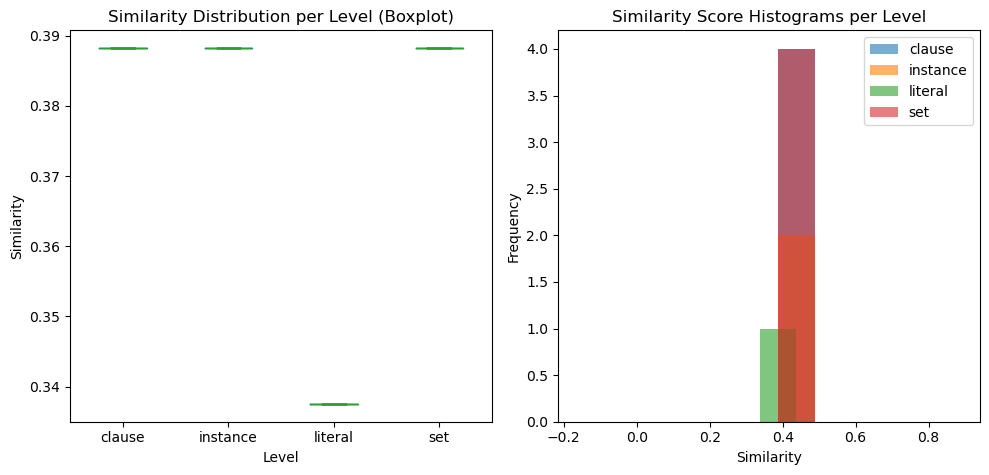

In [27]:
"""
weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Posing", ("Man1", "Tent"))}),
            frozenset({("Posing", ("Man2", "Tent"))}),
            frozenset({("Posing", ("Man3", "Tent"))})
        })
    }),
    "predicate_weights": {
        "Posing": 0.4,
        "¬Posing": 0.0,
        "Eating": 0.0,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "Man1": 0.1,
        "Man2": 0.1,
        "Man3": 0.1,
        "Tent": 0.3,
        "Kitchen": 0.0
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Eating", ("Man1", "Kitchen"))}),
            frozenset({("Eating", ("Man2", "Kitchen"))}),
            frozenset({("Eating", ("Man3", "Kitchen"))})
        })
    }),
    "predicate_weights": {
        "Posing": 0.0,
        "¬Posing": 0.0,
        "Eating": 0.4,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "Man1": 0.1,
        "Man2": 0.1,
        "Man3": 0.1,
        "Tent": 0.0,
        "Kitchen": 0.3
    }
}
"""

weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Posing", ("3Man", "Tent"))})
        })
    }),
    "predicate_weights": {
        "Posing": 0.5,
        "¬Posing": 0.0,
        "Eating": 0.0,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "3Man": 0.2,
        "Tent": 0.3,
        "Kitchen": 0.0
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Eating", ("3Man", "Kitchen"))})
        })
    }),
    "predicate_weights": {
        "Posing": 0.0,
        "¬Posing": 0.0,
        "Eating": 0.5,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "3Man": 0.2,
        "Tent": 0.0,
        "Kitchen": 0.3
    }
}

# --- Paramètres de similarité configurables par niveau ---
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_T1, weighted_T2, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)


🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('PullingUp', ('Jeep',)) ⇄ ('¬PullingUp', ('Jeep',)) → similarity: 0.756 🟡
  ('PullingUp', ('Jeep',)) ⇄ ('Walking', ('Child', 'Street')) → similarity: 0.242 🔴
  ('Walking', ('Child', 'Street')) ⇄ ('¬PullingUp', ('Jeep',)) → similarity: 0.203 🔴

📌 CLAUSE SIMILARITIES (top distinct matches)
  frozenset({('Walking', ('Child', 'Street'))}) ⇄ frozenset({('Walking', ('Child', 'Street'))}) → similarity: 0.781 🟡
  frozenset({('PullingUp', ('Jeep',))}) ⇄ frozenset({('¬PullingUp', ('Jeep',))}) → similarity: 0.604 🟠
  frozenset({('PullingUp', ('Jeep',))}) ⇄ frozenset({('Walking', ('Child', 'Street'))}) → similarity: 0.028 🔴
  frozenset({('Walking', ('Child', 'Street'))}) ⇄ frozenset({('¬PullingUp', ('Jeep',))}) → similarity: 0.017 🔴

📌 SET SIMILARITIES (per clause set)
  Clause set frozenset({('PullingUp', ('Jeep',))}) → similarity: 0.604 🟠
  Clause set frozenset({('Walking', ('Child', 'Street'))}) → similarity: 

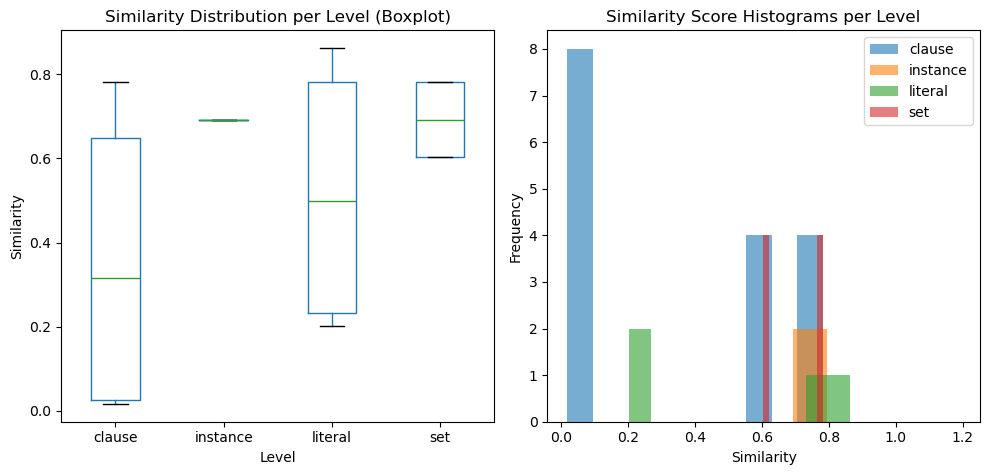

In [28]:
weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Walking", ("Child", "Street"))}),
            frozenset({("PullingUp", ("Jeep",))})
        })
    }),
    "predicate_weights": {
        "Walking": 0.30,
        "PullingUp": 0.25
    },
    "constant_weights": {
        "Child": 0.20,
        "Street": 0.15,
        "Jeep": 0.10
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Walking", ("Child", "Street"))}),
            frozenset({("¬PullingUp", ("Jeep",))})
        })
    }),
    "predicate_weights": {
        "Walking": 0.30,
        "PullingUp": 0.25
    },
    "constant_weights": {
        "Child": 0.20,
        "Street": 0.15,
        "Jeep": 0.10
    }
}

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_T1, weighted_T2, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)


🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('Running', ('Men', 'Beach')) ⇄ ('Running', ('Rocky', 'Beach')) → similarity: 0.637 🟠
  ('Running', ('ApolloCreed', 'Beach')) ⇄ ('Running', ('Men', 'Beach')) → similarity: 0.626 🟠

📌 CLAUSE SIMILARITIES (top distinct matches)
  frozenset({('Running', ('Men', 'Beach'))}) ⇄ frozenset({('Running', ('Rocky', 'Beach'))}) → similarity: 0.719 🟡
  frozenset({('Running', ('ApolloCreed', 'Beach'))}) ⇄ frozenset({('Running', ('Men', 'Beach'))}) → similarity: 0.714 🟡

📌 SET SIMILARITIES (per clause set)
  Clause set frozenset({('Running', ('Rocky', 'Beach'))}) → similarity: 0.719 🟡
  Clause set frozenset({('Running', ('ApolloCreed', 'Beach'))}) → similarity: 0.714 🟡
  Clause set frozenset({('Running', ('Men', 'Beach'))}) → similarity: 0.719 🟡

📌 INSTANCE SIMILARITY (global set-of-sets score)
  (no global similarity computed)
  Instance frozenset({frozenset({('Running', ('Rocky', 'Beach'))}), frozenset({('Running',

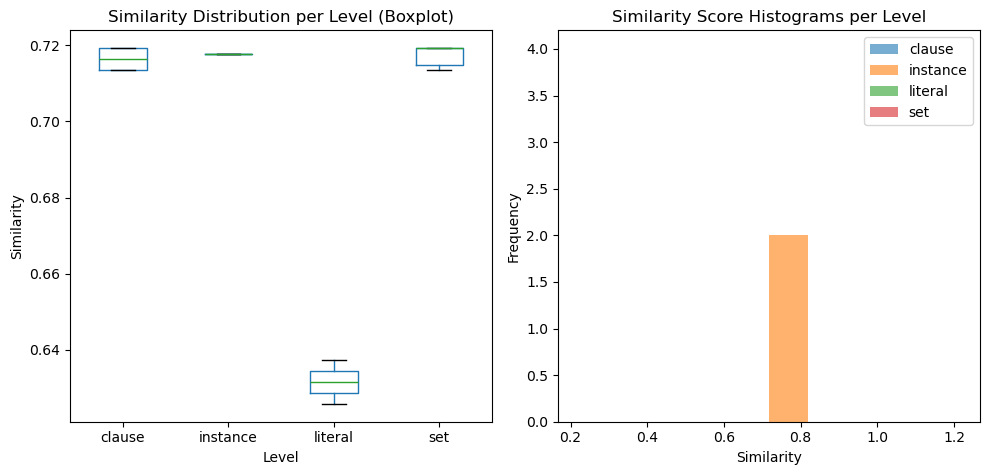

In [29]:
weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Running", ("Rocky", "Beach"))}),
            frozenset({("Running", ("ApolloCreed", "Beach"))})
        })
    }),
    "predicate_weights": {
        "Running": 0.40
    },
    "constant_weights": {
        "Rocky": 0.20,
        "ApolloCreed": 0.20,
        "Beach": 0.20
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Running", ("Men", "Beach"))})
        })
    }),
    "predicate_weights": {
        "Running": 0.40
    },
    "constant_weights": {
        "Men": 0.40,
        "Beach": 0.20
    }
}

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_T1, weighted_T2, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

In [ ]:
weighted_T1 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Smoking", ("Man",))})
        })
    }),
    "predicate_weights": {
        "Smoking": 0.50
    },
    "constant_weights": {
        "Man": 0.50
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({
            frozenset({("Sucking", ("Baby", "Pacifier"))})
        })
    }),
    "predicate_weights": {
        "Sucking": 0.40
    },
    "constant_weights": {
        "Baby": 0.30,
        "Pacifier": 0.30
    }
}

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "strategy": "generalized_tversky_powered",
        "alpha": 0.25,         # paramètre tversky pour les éléments non appariés de clause1
        "beta": 0.25,          # paramètre tversky pour les éléments non appariés de clause2
        "p": 3              
    },
    "set": {
        "method": "chamfer"
    },
    "instance": {
        "method": "chamfer"
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "set": True,
    "instance": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simSetSetClause_simLbert_combined_with_summary(weighted_T1, weighted_T2, params=params, debug=debug_flags)
summarize_debug_output(summary, debug=debug_flags)
print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")


🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL SIMILARITIES (top distinct matches)
  ('Smoking', ('Man',)) ⇄ ('Sucking', ('Baby', 'Pacifier')) → similarity: 0.387 🔴

📌 CLAUSE SIMILARITIES (top distinct matches)
  frozenset({('Smoking', ('Man',))}) ⇄ frozenset({('Sucking', ('Baby', 'Pacifier'))}) → similarity: 0.056 🔴

📌 SET SIMILARITIES (per clause set)
  Clause set frozenset({('Smoking', ('Man',))}) → similarity: 0.056 🔴
  Clause set frozenset({('Sucking', ('Baby', 'Pacifier'))}) → similarity: 0.056 🔴

📌 INSTANCE SIMILARITY (global set-of-sets score)
  (no global similarity computed)
  Instance frozenset({frozenset({('Smoking', ('Man',))})}) → best match similarity: 0.056 🔴
  Instance frozenset({frozenset({('Sucking', ('Baby', 'Pacifier'))})}) → best match similarity: 0.056 🔴

🔷 FINAL SIMILARITY SCORE: 0.056
